**Задание 1.** Реализация k-means без предобработки текста

In [ ]:
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


import keras, torch
from transformers import AutoModel
from transformers import AutoTokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/HW: Машинное обучение/questions_csv.xlsx', sheet_name='Лист2')

In [ ]:
df.head()

,Column1,Column2,Column3,Column4
0,Title,URL,Question,Categories
1,your browser version is not supported using sy...,https://stackoverflow.com/questions/76981459/y...,I'm trying to automate some features and I nee...,"['php', 'symfony', 'web-scraping']"
2,how to get button text value in java,https://stackoverflow.com/questions/76981456/h...,I want to get button text value to do the on c...,"['java', 'button']"
3,How to make sure communication is stable when ...,https://stackoverflow.com/questions/76981455/h...,This is my Node codeasync function runClient()...,"['javascript', 'node.js', 'go', 'zeromq']"
4,Cubical Agda Inclusion Order,https://stackoverflow.com/questions/76981453/c...,I'm almost finished defining an Inclusion Orde...,['agda']


Векторизация с CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

question_texts = df.loc[1:, 'Column3']

count_vectorizer = CountVectorizer()

question_vectors = count_vectorizer.fit_transform(question_texts)

question_vectors.shape

(22123, 251495)

Векторизация с TfidfVectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

tfidf_question_vectors = tfidf_vectorizer.fit_transform(question_texts)

tfidf_question_vectors.shape

(22123, 251495)

Векторизация с Glove с использованием через Gensim

In [ ]:
pip install gensim

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

glove_input_file = '/content/drive/MyDrive/HW: Машинное обучение/glove.6B.300d.txt'
word2vec_output_file = '/content/drive/MyDrive/HW: Машинное обучение/glove.6B.300d.txt.word2vec'

# Конвертация
glove2word2vec(glove_input_file, word2vec_output_file)

model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

<ipython-input-8-ba32c6a7564c>:8: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


In [ ]:
def document_vector(doc):
    words = doc.split()
    valid_words = [word for word in words if word in model.key_to_index]
    if valid_words:
        return np.mean(model[valid_words], axis=0)
    else:
        return np.zeros(model.vector_size)

text_vectors = [document_vector(text) for text in df['Column3']]

Определение количества кластеров метоодом Elbow Method для каждого из способов векторизации

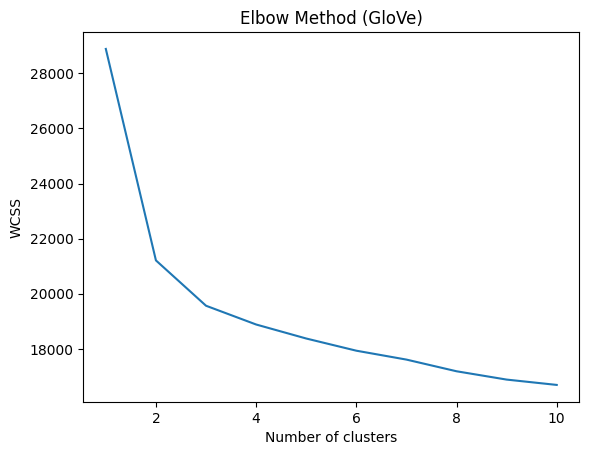

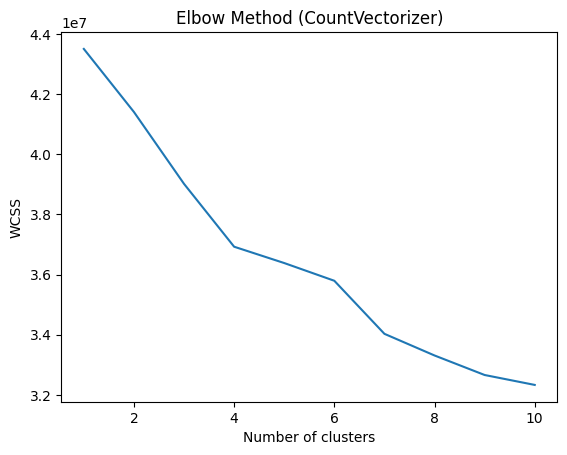

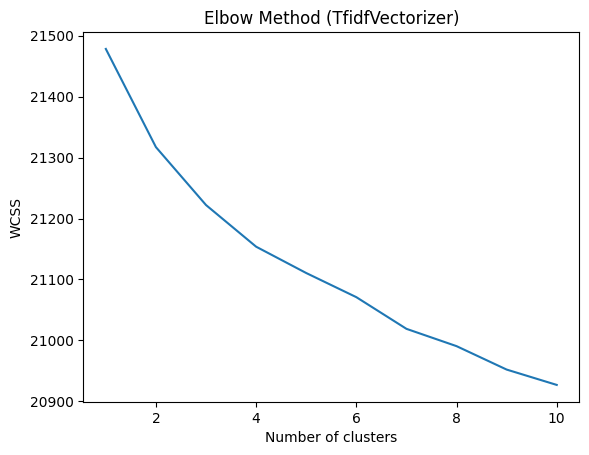

In [ ]:
from sklearn.cluster import KMeans

def plot_elbow_method(vectors, title='Elbow Method'):
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(vectors)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1, 11), wcss)
    plt.title(title)
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

plot_elbow_method(text_vectors, title='Elbow Method (GloVe)')
plot_elbow_method(question_vectors, title='Elbow Method (CountVectorizer)')
plot_elbow_method(tfidf_question_vectors, title='Elbow Method (TfidfVectorizer)')

Выводы по графикам Elbow Method:

1.   Для графика метода локтя **GloVe** оптимальное количество кластеров может быть **около 4**.
2.   В графике метода локтя **CountVectorizer** cнижение WCSS происходит довольно равномерно. Но можно предположить, что после **6 кластеров** замедление становится более заметным.
3.  В графике **TfidfVectorizer** трудно определить оптимальное количество кластеров только по методу локтя. Но можно предположить, что после **6 или 8 кластеров** уменьшение WCSS начинает стабилизироваться.

Определение количества кластеров методом Silhouette для каждого из способов векторизации

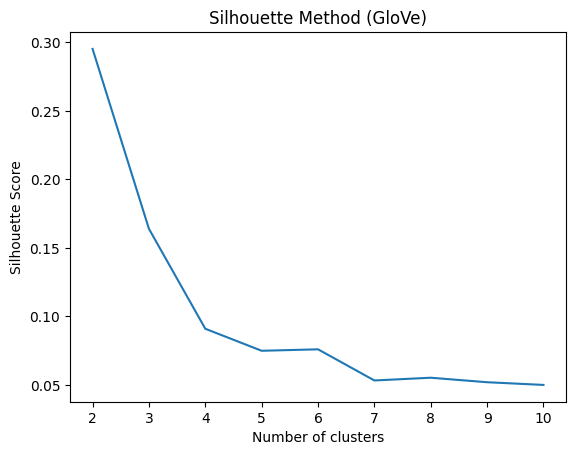

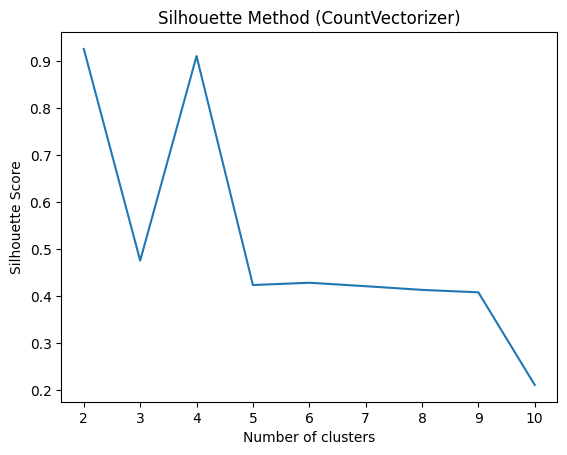

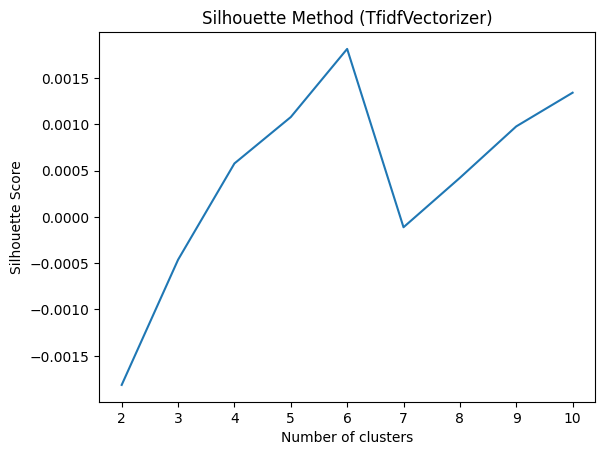

In [ ]:
from sklearn.metrics import silhouette_score

def plot_silhouette_score(vectors, title='Silhouette Method'):
    silhouette_scores = []
    for i in range(2, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(vectors)
        score = silhouette_score(vectors, kmeans.labels_)
        silhouette_scores.append(score)

    plt.plot(range(2, 11), silhouette_scores)
    plt.title(title)
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

plot_silhouette_score(text_vectors, title='Silhouette Method (GloVe)')
plot_silhouette_score(question_vectors, title='Silhouette Method (CountVectorizer)')
plot_silhouette_score(tfidf_question_vectors, title='Silhouette Method (TfidfVectorizer)')

Выводы по графикам Silhouette Method:

1.   На графике метода силуэта для **GloVe**, мы видим, что максимальный коэффициент достигается **при 2 кластерах**.
2.  На графике метода силуэта для **CountVectorizer** наибольший коэффициент достигается **при 4 кластерах**.
3.  На графике метода силуэта для **TfidfVectorizer** наилучший пик виден **при 7 кластерах**, после чего коэффициент снова падает и затем повышается при 9 и 10 кластерах.


### **Суммаризируя результаты, я выбираю следующее количество кластеров:**


**1.**    **GloVe: 2 кластера**. *# хотя метод локтя предлагает 4 кластера, метод силуэта с максимальным значением при 2 кластерах может указывать на более обобщенное разделение данных.*

**2.** **CountVectorizer: 4 кластера.**  *# оба метода показали хорошие результаты при этом количестве*

**3.** **TfidfVectorizer: 7 кластеров.**


In [ ]:
num_clusters_glove = 2
num_clusters_count = 4
num_clusters_tfidf = 7

kmeans_glove = KMeans(n_clusters=num_clusters_glove, random_state=0)
kmeans_count = KMeans(n_clusters=num_clusters_count, random_state=0)
kmeans_tfidf = KMeans(n_clusters=num_clusters_tfidf, random_state=0)

labels_glove = kmeans_glove.fit_predict(text_vectors)
labels_count = kmeans_count.fit_predict(question_vectors)
labels_tfidf = kmeans_tfidf.fit_predict(tfidf_question_vectors)

print("GloVe Clusters:", labels_glove)
print("CountVectorizer Clusters:", labels_count)
print("TfidfVectorizer Clusters:", labels_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


GloVe Clusters: [0 1 0 ... 1 1 1]
CountVectorizer Clusters: [0 0 0 ... 0 0 0]
TfidfVectorizer Clusters: [6 0 0 ... 0 4 2]


In [ ]:
original_texts = df.iloc[:, 2].tolist()

print(original_texts[:5])

['Question', 'I\'m trying to automate some features and I need to scarp a web page.So, I\'m using browserkit to make external request to website.Everything seems good but there\'s no useful result in my response because target page is using modern JavaScript.Let\'s take a look :PHP filerequire "./vendor/autoload.php";use Symfony\\Component\\HttpClient\\HttpClient;$client = HttpClient::create([    \'max_redirects\' => 7,]);$response = $client->request(    \'GET\',    \'https://secure.e-konsulat.gov.pl\');$statusCode = $response->getStatusCode();$contentType = $response->getHeaders()[\'content-type\'][0];$content = $response->getContent();dd($content); //dd() is installed globally on my php installationand this is $content result:^ """<!DOCTYPE html><html lang="en"><head>  <meta charset="utf-8">  <title>System Zdalnej Rejestracji</title>  <base href="/">  <meta name="viewport" content="width=device-width, initial-scale=1">  <link rel="icon" type="image/x-icon" href="favicon.ico">  <link 

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np

def find_closest_texts(data, labels, centroids, original_texts):
    closest_texts = []
    for i in range(len(centroids)):
        indices_in_cluster = np.where(labels == i)[0]

        # Если в кластере нет элементов, пропускаем его
        if indices_in_cluster.size == 0:
            closest_texts.append(None)
            continue

        # Выделяем данные для текущего кластера
        if hasattr(data, "toarray"):
            # Преобразуем в плотный формат только нужные строки
            cluster_data = data[indices_in_cluster].toarray()
        else:
            cluster_data = data[indices_in_cluster]

        # Вычисляем расстояния от центроида кластера до каждой точки в кластере
        distances = euclidean_distances([centroids[i]], cluster_data).flatten()

        # Находим индекс точки с минимальным расстоянием
        min_index = distances.argmin()
        closest_text = original_texts[indices_in_cluster[min_index]]
        closest_texts.append(closest_text)

    return closest_texts

In [ ]:
# Кластеризация с TfidfVectorizer
num_clusters_tfidf = 7  # Количество кластеров
kmeans_tfidf = KMeans(n_clusters=num_clusters_tfidf, random_state=0)
labels_tfidf = kmeans_tfidf.fit_predict(tfidf_question_vectors)

# Поиск ближайших текстов
closest_texts_tfidf = find_closest_texts(tfidf_question_vectors, labels_tfidf, kmeans_tfidf.cluster_centers_, original_texts)
print("Ближайшие тексты для TfidfVectorizer кластеров:", closest_texts_tfidf)

Ближайшие тексты для TfidfVectorizer кластеров: ['Any idea why? The following is my custom theme that was more or less working pre-MDC. I\'ve modified it to support MDC:$custom-typography: mat.define-legacy-typography-config(  $font-family: "Inter, sans-serif",  $button: mat.define-typography-level(14px, 17px, 700),);$app-primary: mat.define-palette($la-purple, 600, 300, 900);$app-accent: mat.define-palette($my-cyan, 700, 300, 1000);$app-warn: mat.define-palette($my-red, 700, 300, 900);$app-base: mat.define-palette($my-grey, 900, 700);// Changing the main text color: https://stackoverflow.com/a/46157803/961609@function app-mat-light-theme-foreground($color) {  @return (    base: $color,    divider: rgba($color, 0.12),    dividers: rgba($color, 0.12),    disabled: rgba(black, 0.38),    disabled-button: rgba($color, 0.26),    disabled-text: rgba($color, 0.38),    elevation: $color,    hint-text: rgba(black, 0.38),    secondary-text: rgba($color, 0.54),    icon: rgba($color, 0.54),    ico

In [ ]:
# Кластеризация с CountVectorizer
from sklearn.cluster import KMeans

num_clusters_count = 4  # Количество кластеров
kmeans_count = KMeans(n_clusters=num_clusters_count, random_state=0)
labels_count = kmeans_count.fit_predict(question_vectors)

# Поиск ближайших текстов
closest_texts_count = find_closest_texts(question_vectors, labels_count, kmeans_count.cluster_centers_, original_texts)
print("Ближайшие тексты для CountVectorizer кластеров:", closest_texts_count)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Кластеризация с GloVe
num_clusters_glove = 2  # Количество кластеров
kmeans_glove = KMeans(n_clusters=num_clusters_glove, random_state=0)
labels_glove = kmeans_glove.fit_predict(np.array(text_vectors))  # Преобразование списка векторов в NumPy массив

# Поиск ближайших текстов
closest_texts_glove = find_closest_texts(np.array(text_vectors), labels_glove, kmeans_glove.cluster_centers_, original_texts)
print("Ближайшие тексты для GloVe кластеров:", closest_texts_glove)

Можно ли с их помощью описать полученный кластер? Не особо.

**Задание 2.** Реализация k-means c предобработкой текста

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 14.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline
import keras, torch
from transformers import AutoModel
from transformers import AutoTokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/HW: Машинное обучение/questions_csv.xlsx', sheet_name='Лист2')

In [ ]:
# Предобработка
import spacy

nlp = spacy.load("en_core_web_sm")

def preprocess_and_lemmatize(text):
    doc = nlp(text.lower())
    lemmas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]
    return " ".join(lemmas)

df['processed_text'] = df.iloc[:, 2].astype(str).apply(preprocess_and_lemmatize)

print(df['processed_text'].head())

0                                             question
1    try automate feature need scarp web browserkit...
2    want button text value click command find righ...
3    node codeasync function runclient hello world ...
4    finish define inclusion order cubical agda sti...
Name: processed_text, dtype: object


1. Векторизация с CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()

question_vectors = count_vectorizer.fit_transform(df['processed_text'])

question_vectors.shape

(22124, 99223)

2. Векторизация с TfidfVectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

tfidf_question_vectors = tfidf_vectorizer.fit_transform(df['processed_text'])

tfidf_question_vectors.shape

(22124, 99223)

3. Векторизация с Glove с использованием через Gensim

In [ ]:
pip install gensim

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import numpy as np

glove_input_file = '/content/drive/MyDrive/HW: Машинное обучение/glove.6B.300d.txt'
word2vec_output_file = '/content/drive/MyDrive/HW: Машинное обучение/glove.6B.300d.txt.word2vec'

# Конвертация
glove2word2vec(glove_input_file, word2vec_output_file)

model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

def document_vector(doc):
    words = doc.split()
    valid_words = [word for word in words if word in model.key_to_index]
    if valid_words:
        return np.mean(model[valid_words], axis=0)
    else:
        return np.zeros(model.vector_size)

text_vectors = [document_vector(text) for text in df['processed_text']]

<ipython-input-9-aed91bff1cc3>:9: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


Определение количества кластеров метоодом Elbow Method для каждого из способов векторизации

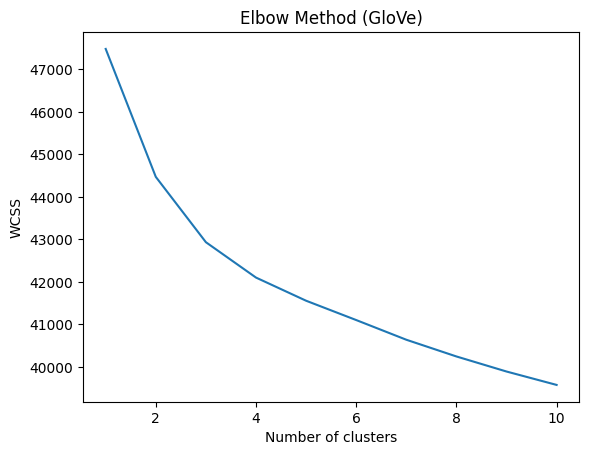

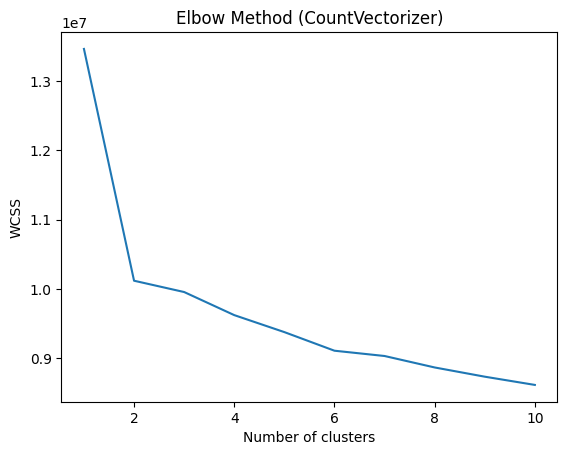

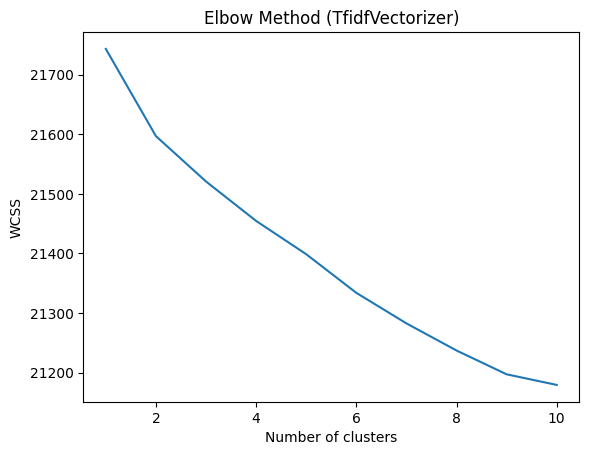

In [ ]:
from sklearn.cluster import KMeans

def plot_elbow_method(vectors, title='Elbow Method'):
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(vectors)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1, 11), wcss)
    plt.title(title)
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

plot_elbow_method(text_vectors, title='Elbow Method (GloVe)')
plot_elbow_method(question_vectors, title='Elbow Method (CountVectorizer)')
plot_elbow_method(tfidf_question_vectors, title='Elbow Method (TfidfVectorizer)')

**Выводы по графикам Elbow Method:**


1.   На графике для **GloVe** заметно, что существенное уменьшение WCSS до центров кластеров происходит в интервале от 2 до 4 кластеров Оптимальное количество может считать равным **4 кластерам**, так как  после 4 увеличение числа кластеров не дает значительного улучшения.
2.   Для **CountVectorizer** кривая показывает сильное падение WCSS при увеличении числа кластеров с 2 до 4. После этого падение замедляется, но все еще продолжается до 6 кластеров. Оптимальное количество для CountVectorizer может быть выбрано равным **6 кластерам**.
3.  График для **TfidfVectorizer** похож на GloVe, поэтому оптимальное количество также может быть равным **4 кластерам**.



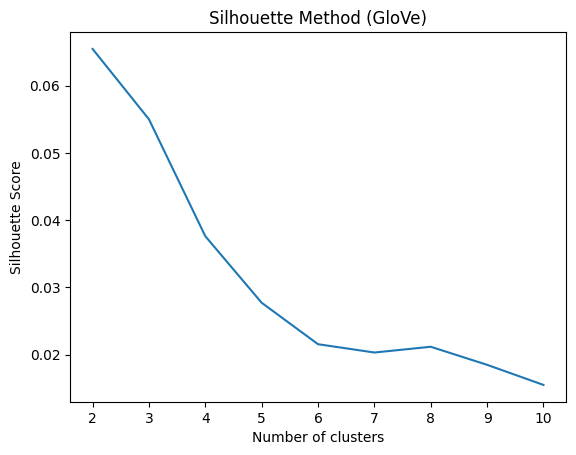

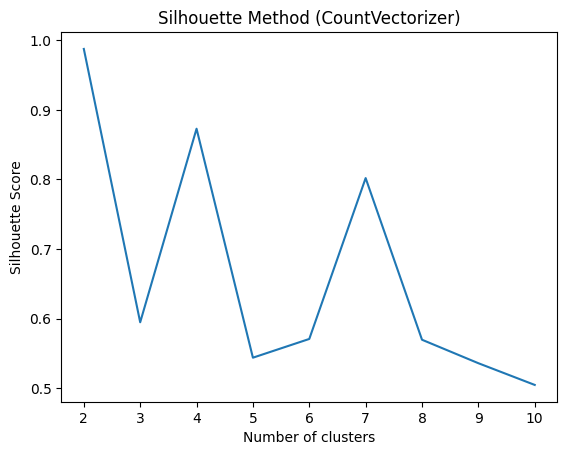

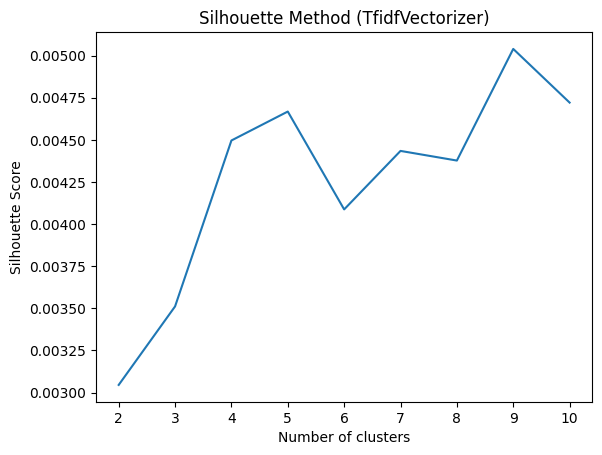

In [ ]:
from sklearn.metrics import silhouette_score

def plot_silhouette_score(vectors, title='Silhouette Method'):
    silhouette_scores = []
    for i in range(2, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(vectors)
        score = silhouette_score(vectors, kmeans.labels_)
        silhouette_scores.append(score)

    plt.plot(range(2, 11), silhouette_scores)
    plt.title(title)
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

plot_silhouette_score(text_vectors, title='Silhouette Method (GloVe)')
plot_silhouette_score(question_vectors, title='Silhouette Method (CountVectorizer)')
plot_silhouette_score(tfidf_question_vectors, title='Silhouette Method (TfidfVectorizer)')

**Выводы по графикам Silhouette Method:**



1.   На графике силуэтного метода для **GloVe** наиболее высокое значение наблюдается при 2 кластерах, после чего кривая плавно снижается. Поэтому оптимальное количество для GloVe, вероятно, равно **2 кластерам**.
2.   График силуэтного метода для **CountVectorizer** показывает необычное колебание при 3 и 5 кластерах. Особенно выраженный пик при 5. Это может указывать на то, что **5 кластеров** является оптимальным выбором для CountVectorizer.
3.  На графике силуэтного метода для **TfidfVectorizer** видно, что силуэтный коэффициент достигает пика при 5 кластерах, затем немного падает и снова возрастает при 8 кластерах. Пик при **5 кластерах** выглядит более выраженным, поэтому его можно считать оптимальным количеством.



**Суммаризируя результаты, я выбираю следующее количество кластеров:**

Для GloVe — 2 кластера.
Для CountVectorizer и TfidfVectorizer — 5 кластеров.

In [ ]:
num_clusters_glove = 2
num_clusters_count = 5
num_clusters_tfidf = 5

kmeans_glove = KMeans(n_clusters=num_clusters_glove, random_state=0)
kmeans_count = KMeans(n_clusters=num_clusters_count, random_state=0)
kmeans_tfidf = KMeans(n_clusters=num_clusters_tfidf, random_state=0)

labels_glove = kmeans_glove.fit_predict(text_vectors)
labels_count = kmeans_count.fit_predict(question_vectors)
labels_tfidf = kmeans_tfidf.fit_predict(tfidf_question_vectors)

print("GloVe Clusters:", labels_glove)
print("CountVectorizer Clusters:", labels_count)
print("TfidfVectorizer Clusters:", labels_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


GloVe Clusters: [0 1 0 ... 0 1 0]
CountVectorizer Clusters: [0 0 0 ... 0 0 0]
TfidfVectorizer Clusters: [4 1 0 ... 2 2 4]


In [ ]:
original_texts = df['processed_text'].tolist()

print(original_texts[:5])

['question', 'try automate feature need scarp web browserkit external request good useful result response target page modern look php filerequire instal globally php installationand content doctype meta title system zdalnej base meta device width initial link x icon link style style s materialicon fluhrq size border prefer reduce motion behavior family f lt ie div border solid ministerstwa spraw zagranicznych rzeczypospolitej div size margin auto max width text align center br p dear p browser version support actualize browser use app line p dear browser version support actualize browser use onedo know solve mention experience web scrape detailed answer advance', 'want button text value click command find right code think need code replace text code show class main implement static void args jframe frame new jframe jbutton button new jbutton public void e text text', 'node codeasync function runclient hello world serverвђ socket talk server const sock new let true const msgtosend hello

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np

def find_closest_texts(data, labels, centroids, original_texts):
    closest_texts = []
    for i in range(len(centroids)):
        indices_in_cluster = np.where(labels == i)[0]

        # Если в кластере нет элементов, пропускаем его
        if indices_in_cluster.size == 0:
            closest_texts.append(None)
            continue

        # Выделяем данные для текущего кластера
        # Проверяем, является ли data разреженной матрицей
        if hasattr(data, "toarray"):
            # Преобразуем в плотный формат только нужные строки
            cluster_data = data[indices_in_cluster].toarray()
        else:
            cluster_data = data[indices_in_cluster]

        # Вычисляем расстояния от центроида кластера до каждой точки в кластере
        distances = euclidean_distances([centroids[i]], cluster_data).flatten()

        # Находим индекс точки с минимальным расстоянием
        min_index = distances.argmin()
        closest_text = original_texts[indices_in_cluster[min_index]]
        closest_texts.append(closest_text)

    return closest_texts

In [ ]:
# Кластеризация с TfidfVectorizer
num_clusters_tfidf = 7 # Количество кластеров
kmeans_tfidf = KMeans(n_clusters=num_clusters_tfidf, random_state=0)
labels_tfidf = kmeans_tfidf.fit_predict(tfidf_question_vectors)

# Поиск ближайших текстов
closest_texts_tfidf = find_closest_texts(tfidf_question_vectors, labels_tfidf, kmeans_tfidf.cluster_centers_, original_texts)
print("Ближайшие тексты для TfidfVectorizer кластеров:", closest_texts_tfidf)

Ближайшие тексты для TfidfVectorizer кластеров: ['close question programming software development currently accept question appear specific programming problem software algorithm software tool primarily programmer believe question topic stack exchange site leave comment explain question able day questionhere want check ip address want open web page browser', 'want excel file name current file path try file f f return want result like try file f f contain file want excel file', 'completely give hope solve problem hopefully help reason class recognize entity get follow error cause error create bean cardrepository define define declare hibernateconfig manage type class common frame omittedcause manage type class data data data data data data data data data data data data class project configuration work fine refuse baseentity abstract class card user inherit abstract class baseentity private long d private date create private date update private boolean visible public baseentity new date 

In [ ]:
# Кластеризация с CountVectorizer
num_clusters_count = 4  # Количество кластеров
kmeans_count = KMeans(n_clusters=num_clusters_count, random_state=0)
labels_count = kmeans_count.fit_predict(question_vectors)

# Поиск ближайших текстов
closest_texts_count = find_closest_texts(question_vectors, labels_count, kmeans_count.cluster_centers_, original_texts)
print("Ближайшие тексты для CountVectorizer кластеров:", closest_texts_count)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Кластеризация с GloVe
num_clusters_glove = 2  # Количество кластеров
kmeans_glove = KMeans(n_clusters=num_clusters_glove, random_state=0)
labels_glove = kmeans_glove.fit_predict(np.array(text_vectors))  # Преобразование списка векторов в NumPy массив

# Поиск ближайших текстов
closest_texts_glove = find_closest_texts(np.array(text_vectors), labels_glove, kmeans_glove.cluster_centers_, original_texts)
print("Ближайшие тексты для GloVe кластеров:", closest_texts_glove)

Можно ли с их помощью описать полученный кластер? Вроде, да.



**Задание 3.** Кластеризация DBSCAN

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 26.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/HW: Машинное обучение/questions_csv.xlsx', sheet_name='Лист2')

In [ ]:
# Предобработка
import spacy

nlp = spacy.load("en_core_web_sm")

def preprocess_and_lemmatize(text):
    doc = nlp(text.lower())
    lemmas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]
    return " ".join(lemmas)

df['processed_text'] = df.iloc[:, 2].astype(str).apply(preprocess_and_lemmatize)

print(df['processed_text'].head())

0                                             question
1    try automate feature need scarp web browserkit...
2    want button text value click command find righ...
3    node codeasync function runclient hello world ...
4    finish define inclusion order cubical agda sti...
Name: processed_text, dtype: object


Векторизация с TfidfVectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df['processed_text'])

Применение DBSCAN

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


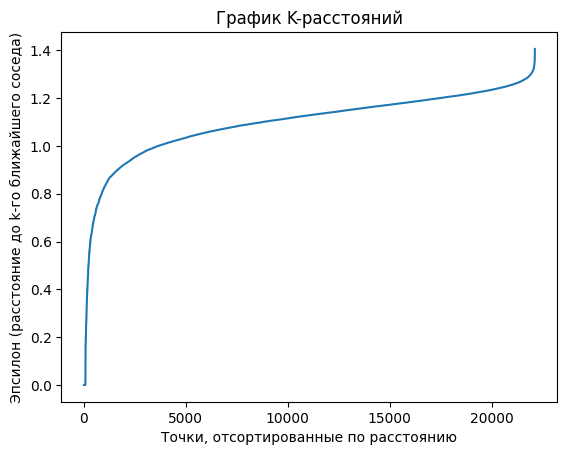

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

neigh = NearestNeighbors(n_neighbors=2, algorithm='ball_tree', n_jobs=-1)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.title('График K-расстояний')
plt.xlabel('Точки, отсортированные по расстоянию')
plt.ylabel('Эпсилон (расстояние до k-го ближайшего соседа)')
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.2, min_samples=5)
clusters = dbscan.fit_predict(X)

print("Количество уникальных кластеров (включая шум):", len(set(clusters)))
print("Примеры меток кластеров"), clusters[:10]

Количество уникальных кластеров (включая шум): 20
Примеры меток кластеров


(None, array([ 0, -1,  0, -1, -1,  0,  0,  0,  0, -1]))

Результаты DBSCAN показали 20 кластеров, включая данные, классифицированные как шум. Это количество кластеров и шума могут указывать на более детализированное или раздробленное разбиение данных по сравнению с  k-means.